In [1]:
# Sample code for MPS of random vector
# 2017 Augst Tsuyoshi Okubo
# 2018 Feb. Bug fixed 
# 2019 Jun. Modified the output
# 2020 Jun. Modified the output
# 2020 Oct. Modfied by TO
# 2020 Dec. Add appendix 

In this code, we perform a matrix product (a tensor train) decomposition for a random vector. 
The input parameters are
* $N$ : number of "site"
* $m$ : "local dimension". (Total vector dimension is $m^N$.)
* chi_max : maximum bond dimension of MPS
* seed : the seed for random number generator (When you set an interger, the same random vecotr will be created repetedly.)

We preper a random vector with the dimension $ m^N$, and construct the exact matrix product state (tensor train decomposition). Then we truncate the each bond dimension to "chi_max" and make an approximated vector.
Finally, the code calculate the distance between the exact vector and the approximated vector. 

In the appedix, we calculate chi_max dependece of the distance.

In [2]:
import numpy as np
import scipy.linalg as linalg
import argparse
import copy
import MPS
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
## Set parameters
N = 16 ## set "system size" N 
m = 2 ## vector size m: total dimension is m^N
chi_max = 20 ## maximum bond dimension at truncation
seed = None ## The seed for random numnber generator. 

In [4]:
def calc_innerproduct(Tn1,lam1,Tn2,lam2):


    chi1 = Tn1[0].shape[2]
    chi2 = Tn2[0].shape[2]

    vec = np.tensordot(Tn1[0],Tn2[0].conj(),axes=(0,0)).reshape(chi1,chi2)

    for i in range(1,len(Tn1)):
        vec = np.tensordot(np.tensordot(np.tensordot(np.tensordot(vec,np.diag(lam1[i]),(0,0)),np.diag(lam2[i]),(0,0)),Tn1[i],(0,1)),Tn2[i].conj(),([0,1],[1,0]))

    return vec.reshape(1)[0]

In [5]:
def remake_vec(Tn,lam):

    chi = Tn[0].shape[2]
    m = Tn[0].shape[0]
    vec = np.reshape(Tn[0],(m,chi))

    for i in range(1,len(Tn)):
        vec = np.tensordot(np.tensordot(vec,np.diag(lam[i]),(i,0)),Tn[i],(i,1))
    return vec.flatten()

In [6]:
## Main calculation

if seed != None:
    np.random.seed(seed)
        
    
print("Parameters: N, m, chi_max = "+repr(N)+", "+repr(m)+ ", "+repr(chi_max))
print("Random seed: = "+repr(seed))

## create random vecgtor
eig_vec = ((np.random.rand(m**N)-0.5) + 1.0j * (np.random.rand(m**N)-0.5)).reshape(m**N)
## normalization
norm = np.tensordot(eig_vec,eig_vec.conj(),axes=(0,0))
eig_vec /= np.sqrt(np.abs(norm))


Parameters: N, m, chi_max = 16, 2, 20
Random seed: = None


In [7]:
## Make exact MPS (from "left")
Tn = []
lam = [np.ones((1,))]
lam_inv = 1.0/lam[0]
R_mat = eig_vec[:].reshape(m,m**(N-1))

chi_l=1
for i in range(N-1):
    U,s,VT = linalg.svd(R_mat,full_matrices=False)
    chi_r = s.size

    Tn.append(np.tensordot(np.diag(lam_inv),U.reshape(chi_l,m,chi_r),(1,0)).transpose(1,0,2))
    lam.append(s)
    lam_inv = 1.0/s
    R_mat = np.dot(np.diag(s),VT).reshape(chi_r*m,m**(N-i-2))
    chi_l = chi_r
Tn.append(VT.reshape(m,m,1).transpose(1,0,2))
lam.append(np.ones((1,)))


In [8]:
## Truncation to chi_max

Tn_ex = copy.deepcopy(Tn)
lam_ex = copy.deepcopy(lam)

#Tn_ex = Tn
#lam_ex = lam
for i in range(N-1):
    chi = min(chi_max,lam[i+1].shape[0])
    lam[i+1]=lam[i+1][:chi]
    Tn[i]=Tn[i][:,:,:chi]
    Tn[i+1]=Tn[i+1][:,:chi,:]

print("Truncation: chi_max = "+repr(chi_max))


Truncation: chi_max = 20


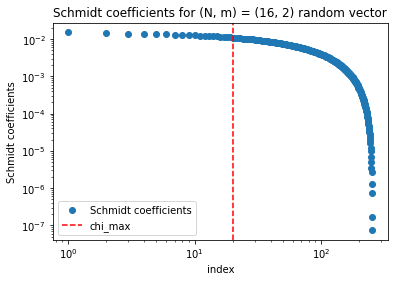

In [9]:
## plot Schmidt coefficient at N/2
## Red line indicates the position of chi_max

plt.title("Schmidt coefficients for "+"(N, m) = ("+repr(N)+", "+repr(m)+") random vector")
plt.plot(np.arange(len(lam_ex[N//2]))+1,lam_ex[N//2]**2,"o",label="Schmidt coefficients")
plt.axvline([chi_max],0,1,  c="red", linestyle='dashed', label="chi_max") ## position of chi_max
plt.xlabel("index")
plt.xscale("log")
plt.ylabel("Schmidt coefficients")
plt.yscale("log")
plt.legend()
plt.show()




In [10]:
## Distance between Exact MPS and truncated MPS

vec_ex = MPS.remake_vec(Tn_ex,lam_ex)
vec_ap = MPS.remake_vec(Tn,lam)
print("Distance between exact and truncated MPS = "+repr(linalg.norm(vec_ex - vec_ap)))


Distance between exact and truncated MPS = 0.98489819317225


## Appendix: bond dimension dependence 

In this appendix, we calculate the distance between the original and approximated vector as a function of chi_max.   
We use the same original vector as the main part.   
You can set maxmum and minimum value of chi_max for the calculation.


In [11]:
min_chi_max = 10
max_chi_max = 260 ## maximum bond dimension of the exact MPS is m**(N/2)
d_chi_max = 10

In [12]:
chi_max_list = np.arange(min_chi_max, max_chi_max+1, d_chi_max, dtype=int)
chi_list = np.ones((N+1,),dtype=int)
vec_ex = MPS.remake_vec(Tn_ex,lam_ex)

distances=[]
for chi_max in chi_max_list:
    for i in range(N-1):
        chi = min(chi_max,lam_ex[i+1].shape[0])
        chi_list[i+1] = chi
    lam = [np.ones((1,))]
    Tn = []
    for i in range(N):
        lam.append(lam_ex[i+1][:chi_list[i+1]])
        Tn.append(Tn_ex[i][:,:chi_list[i],:chi_list[i+1]])
    vec_ap = MPS.remake_vec(Tn,lam)
    distances.append(linalg.norm(vec_ex - vec_ap))

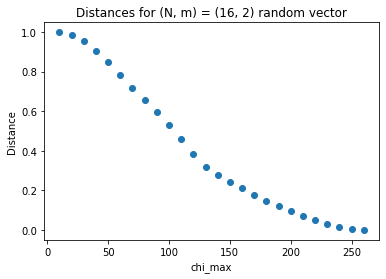

In [13]:
## plot distances

plt.title("Distances for "+"(N, m) = ("+repr(N)+", "+repr(m)+") random vector")
plt.plot(chi_max_list,distances,"o")
plt.xlabel("chi_max")
plt.ylabel("Distance")
#plt.yscale("log")
plt.show()

